In [1]:
pip install statsmodels

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

In [3]:
sns.set(style="ticks")
sns.set_palette("colorblind")
# TODO
mpl.rcParams['font.size'] = 9 # This should set the size to 9pt

# 1. Question – What makes a Munro popular?

In [4]:
# Load dataset
munro = pd.read_csv('datasets/clean.csv')
munro.head()

,name,altitude,ascent_count,rating,region,report_count,rating_count,bb_count,hotel_count,hostel_count,...,neighbor_count_15,neighbor_count_20,nearest_city_dist,nearest_city_population,population_25,population_50,population_75,population_100,beginner_friendly,national_park
0,Ben Nevis,1345,17902,3.84,Fort William,316,253,72,41,18,...,20,29,6.68,10459,10459,10459,19034,242223,0,NaN
1,Ben Macdui,1309,10449,3.78,Cairngorms,215,162,37,29,9,...,17,20,56.26,70000,0,0,158093,762982,0,Cairngorms
2,Braeriach,1296,6035,3.95,Cairngorms,141,94,37,29,9,...,16,20,53.49,70000,0,0,150894,762982,0,Cairngorms
3,Cairn Toul,1291,5121,3.86,Cairngorms,136,83,37,29,9,...,18,21,56.30,70000,0,0,205053,771982,0,Cairngorms
4,Sgor an Lochain Uaine,1258,4832,3.83,Cairngorms,139,79,37,29,9,...,18,20,55.43,70000,0,0,158093,771982,0,Cairngorms


### 1. Visualise the distribution of Munro heights and frequency of them being climbed

#### Distribution of number of ascents

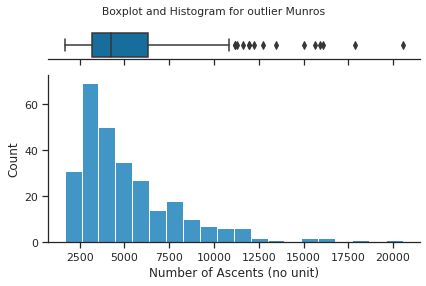

In [5]:
_, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(6,4))

# Box plot
sns.boxplot(x=munro['ascent_count'], ax=ax_box)
sns.despine(ax=ax_box, left=True)  # Remove border
ax_box.get_yaxis().set_visible(False)
ax_box.set_xlabel(None)

# Histogram
sns.histplot(munro['ascent_count'], ax=ax_hist, bins='fd')
sns.despine(ax=ax_hist)  # Remove border
ax_hist.set_ylabel('Count')
ax_hist.set_xlabel('Number of Ascents (no unit)')

plt.suptitle('Boxplot and Histogram for outlier Munros')
plt.tight_layout()

plt.savefig("ascent_distribution.pdf")

plt.show()

The boxplot indicates that, in terms of number of ascents, an outlier is any Munro for which the number of ascents is above ~11,000. We now determine this value exactly:

In [6]:
# Code snippet adapted from: https://datascience.stackexchange.com/questions/54808/how-to-remove-outliers-using-box-plot
Q1 = munro['ascent_count'].quantile(0.25)
Q3 = munro['ascent_count'].quantile(0.75)
IQR = Q3 - Q1 # Interquartile range

cutoff_ascent_count = Q3 + 1.5 * IQR
cutoff_ascent_count = int(cutoff_ascent_count.round(0))  # Round to the nearest integer
print('Cutoff ascent count for outlier:  {}'.format(cutoff_ascent_count))

Cutoff ascent count for outlier:  11018


#### Distribution of altitude

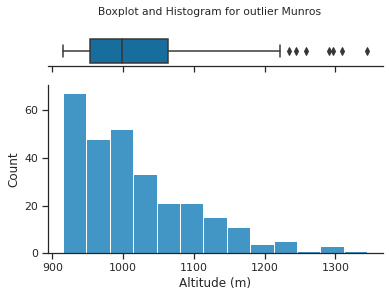

In [7]:
_, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(6,4))

# Box plot
sns.boxplot(x=munro['altitude'], ax=ax_box)
sns.despine(ax=ax_box, left=True)  # Remove border
ax_box.get_yaxis().set_visible(False)
ax_box.set_xlabel(None)

# Histogram
sns.histplot(munro['altitude'], ax=ax_hist, bins='fd')
sns.despine(ax=ax_hist)  # Remove border
ax_hist.set_ylabel('Count')
ax_hist.set_xlabel('Altitude (m)')

plt.suptitle('Boxplot and Histogram for outlier Munros')

plt.savefig("altitude_distribution.pdf")

plt.show()

The boxplot indicates that, in terms of altitude, an outlier is any Munro with a height above ~1250m. Again, we determine this value exactly:

In [8]:
# Code snippet adapted from: https://datascience.stackexchange.com/questions/54808/how-to-remove-outliers-using-box-plot
Q1 = munro['altitude'].quantile(0.25)
Q3 = munro['altitude'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

cutoff_altitude = Q3 + 1.5 * IQR
cutoff_altitude = int(cutoff_altitude.round(0))  # Round to the nearest integer
print('Cutoff altitude for outlier:  {}'.format(cutoff_altitude))

Cutoff altitude for outlier:  1229


#### Joint distribution of altitude and ascent count

We wish to get a summary view of both variables at once. To that end, we plot the joint distribution of altitude and ascent.

<Figure size 576x576 with 0 Axes>

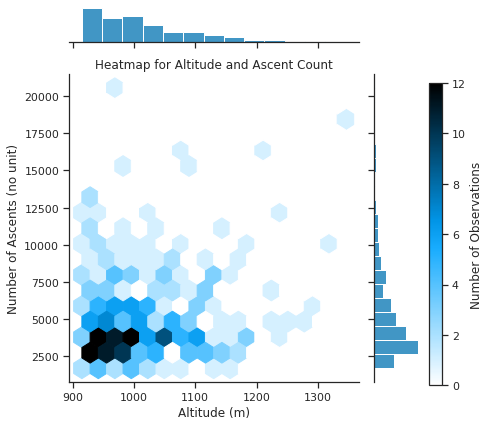

In [9]:
plt.figure(figsize=(8,8))

# Joint distribution
ax = sns.jointplot(x='altitude', y='ascent_count', data=munro, kind='hex')
plt.ylabel('Number of Ascents (no unit)')
plt.xlabel('Altitude (m)')
plt.title('Heatmap for Altitude and Ascent Count')
plt.tight_layout()

# Add colorbar
cbar_ax = ax.fig.add_axes([1, 0.1, .03, .7])
cb = plt.colorbar(cax=cbar_ax)
cb.set_label('Number of Observations')

plt.savefig("heatmap_joint_distribution.pdf")

plt.show()

The above plot tells us that the majority of Munros has an altitude between 900 and 1000m, and an ascent count of 2500 to 3000. As we previously noted, there are apparent outliers. We treat these below:

### 2. Identify outliers and reason about them
Note: also refer to Google docs

In [10]:
# Separate outliers and non-outliers
mask_outliers = (munro['ascent_count'] <= cutoff_ascent_count) & (munro['altitude'] <= cutoff_altitude)
df_no_outliers = munro.loc[mask_outliers]
df_outliers = munro.loc[~mask_outliers]

In [11]:
# Note for Tudor: the below two cells are merely there to help you notice any other apparent outliers besides Ben Nevis and Lomond

In [12]:
df_outliers['name']

0                      Ben Nevis
1                     Ben Macdui
2                      Braeriach
3                     Cairn Toul
4          Sgor an Lochain Uaine
5                     Cairn Gorm
6      Aonach Beag (Nevis Range)
9                     Ben Lawers
20                     Lochnagar
46                   Beinn Ghlas
57                  Schiehallion
117                    Beinn Ime
164      Ben Vorlich (Loch Earn)
183                   Ben Lomond
218                       Driesh
246                The Cairnwell
249                  Ben Chonzie
252                        Mayar
258                Beinn Narnain
277                   Carn Aosda
Name: name, dtype: object

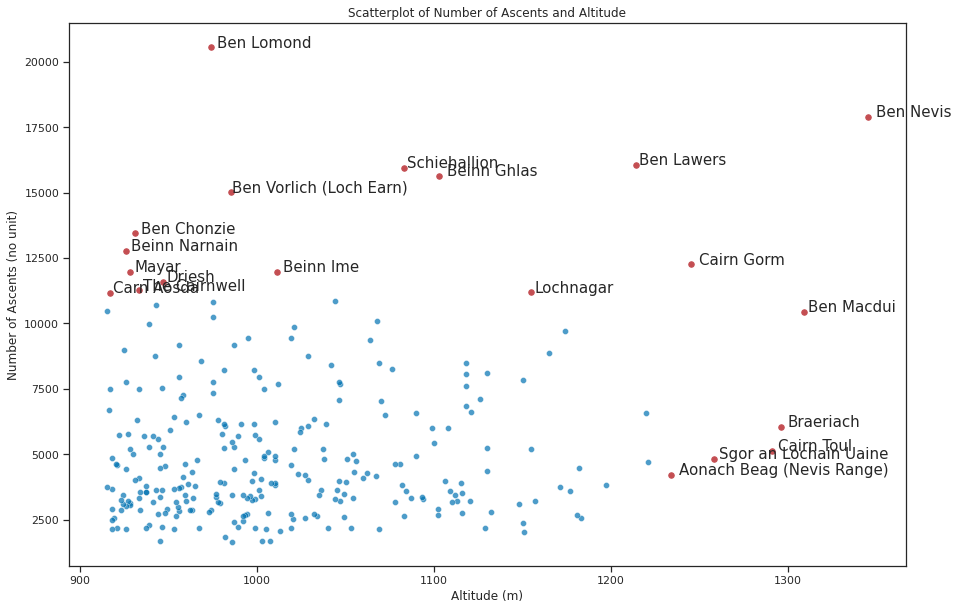

In [13]:
def show_outlier(row):
    plt.scatter(row['altitude'], row['ascent_count'], c='r', s=30)
    # Annotate outlier, add random noise to x,y coordinates to remedy overlaps
    plt.annotate(row['name'], (row['altitude']+np.random.uniform(5), row['ascent_count']+np.random.uniform(20)), size=15)

plt.figure(figsize=(15,10))
sns.scatterplot(x='altitude', y='ascent_count', data=df_no_outliers, alpha = 0.7)

# Annotate outliers
df_outliers.apply(show_outlier, axis=1)

plt.title('Scatterplot of Number of Ascents and Altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Number of Ascents (no unit)')
plt.show()

In [14]:
# Note for Tudor: official work continues from here

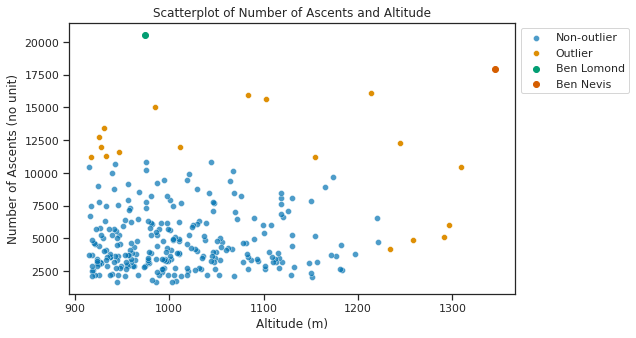

In [15]:
plt.figure(figsize=(8,5))

# Plot regular
sns.scatterplot(x='altitude', y='ascent_count', data=df_no_outliers, label='Non-outlier', alpha = 0.7)

# Plot outliers
sns.scatterplot(x='altitude', y='ascent_count', data=df_outliers, label='Outlier')

# Plot identified outliers
for identified_outlier in ['Ben Lomond', 'Ben Nevis']:  # TODO: for Tudor: please add more specific outliers if you notice any, thanks.
    b = munro.loc[munro['name'] == identified_outlier]
    plt.scatter('altitude', 'ascent_count', data=b, label=identified_outlier)

plt.title('Scatterplot of Number of Ascents and Altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Number of Ascents (no unit)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig("scatterplot.pdf", bbox_inches='tight') # set bbox_inches to tight to prevent the legend from being cropped

plt.show()

There are some noticeable outliers. However, as the <insert reasoning\> about e.g. Ben Nevis or Ben Lomond shows, it is completely possible to attain these datapoints. They are therefore valid and shall be included in our statistical analysis.

### 3. Is there a statistically significant relationship between height and frequency of climb?

Note: we do not work with frequency of climb, but rather with the number of climbs.
Judging by the above scatterplot, there appears to be no apparent, strong relationship between said variables. However, the outliers (e.g. Ben Nevis) exert a leverage and we expect to see a positive relationship between number of ascents and altitude. Our conclusions will be marred due to the large variance in the left-hand side of the scatterplot.

<!-- lmk what you think about the wording please, ofc please correct anything that's off, thank you -->

Define the null and alternate hypotheses:

$H_0$ = there is _not_ a statistically significant relationship between altitude and number of ascents.

$H_a$ = there _is_ a statistically significant relationship between altitude and number of ascents.

We apply linear regression and observe the output of `statsmodels`. This will show us whether the relationship between ascent couunt and altitude could be due to chance.

In [16]:
# Fit model
model = smf.ols('ascent_count ~ altitude', data=munro)
results = model.fit()

In [17]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ascent_count   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5.351
Date:                Wed, 31 Mar 2021   Prob (F-statistic):             0.0214
Time:                        15:54:42   Log-Likelihood:                -2656.6
No. Observations:                 282   AIC:                             5317.
Df Residuals:                     280   BIC:                             5324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    209.0351   2179.614      0.096      0.9

The second error message indicates that there is numerical instability (multicollinearity is out of question as there is a single predictor). We remedy this by centering the independent variable around 0: (TODO: better explanation)

In [18]:
munro_mod = munro.copy()
munro_mod['altitude'] = munro_mod['altitude'] - munro_mod['altitude'].mean()  # center the values around 0 on the x-axis
# Fit model
model = smf.ols('ascent_count ~ altitude', data=munro_mod)
results = model.fit()

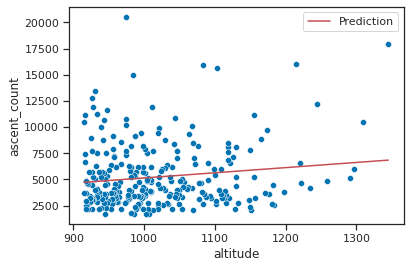

                            OLS Regression Results                            
Dep. Variable:           ascent_count   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5.351
Date:                Wed, 31 Mar 2021   Prob (F-statistic):             0.0214
Time:                        15:54:45   Log-Likelihood:                -2656.6
No. Observations:                 282   AIC:                             5317.
Df Residuals:                     280   BIC:                             5324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5233.8865    178.412     29.336      0.0

In [19]:
sns.scatterplot(data=munro, y='ascent_count', x='altitude')
y_hat = results.predict(munro_mod['altitude'])  # Predicted data
sns.lineplot(x=munro['altitude'], y=y_hat, color='r', label='Prediction')

# plt.suptitle('Prediction Over Raw Data')
plt.legend()
plt.savefig('q1_prediction.pdf', bbox_inches='tight')
plt.show()

print(results.summary())

- The $p$-value tells us that there is a 2% probability that the relationship between altitude and ascent count may be due to chance. Since 0.021 < 0.05, it allows us to reject the null hypothesis that the coefficient of altitude in the model equals 0 at the 5% level. Furthermore, the t score is fairly high too, to further assert our claim. Thus, there is a statistically significant relationship between altitude and ascent count.
- However,we observe that the $R^2$ value is quite low at 0.019. This tells us that the model does not fit the data too well. This motivates the use of further predictors to aid our analysis.
- Since we standardised the independent variable (i.e. it has mean 0), the intercept tells us the expected ascent count for a Munro of mean altitude.
- NEW: The coefficient of altitude tells us that each extra meter of altitude leads to ~5 ascents. The confidence interval tells us that in 95% of all samples that could be drawn, \[0.736, 9.138\] will include the true value of the coefficient for altitude.

In [20]:
# RMSE and MSE
# TODO: relative measure of error?
print('MSE: {}'.format(results.mse_total))
print('RMSE:  {}'.format(np.sqrt(results.mse_total)))

MSE: 9115233.844728805
RMSE:  3019.1445551229913


The root mean square error indicates how far predictions of ascent count deviate from actual observed values, in absolute terms. The RMSE tells us that this deviation is about 3000. Given that the mean ascent count is approximately 5200, this is a relatively large deviation.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


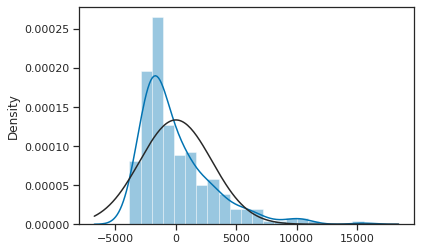

In [21]:
# Plot the distribution of residuals
sns.distplot(results.resid, fit=stats.norm)
plt.savefig('residuals_dist.pdf', bbox_inches='tight')
# plt.title('Distribution of Residuals')
plt.show()

A good Linear regression fit requires the residuals to be normally distributed. This is not exactly a normal distribution, and is fairly skewed. This is not what we are looking for. 

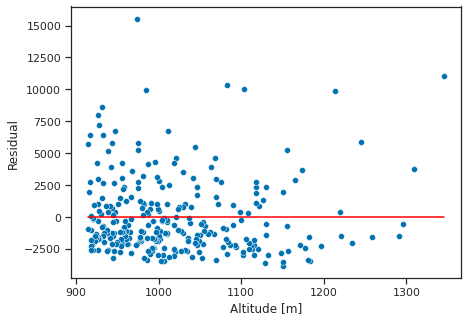

In [22]:
fig, ax = plt.subplots(figsize=(7,5))
scatter = sns.scatterplot(x=munro['altitude'], y=results.resid)

ax.set_ylabel('Residual')
ax.set_xlabel('Altitude [m]')
# ax.set_title('Residual Plot')

sns.lineplot(x=munro['altitude'], y=0, color='red')

plt.savefig('residuals_plot.pdf', bbox_inches='tight')
plt.show()

The plot is not heteroskedastic. There is no obvious pattern observed – the independent variable and variance do not exhibit a relationship. Therefore, a linear model is not a bad choice.

### 4. How much can we trust the conclusions given the nature of the data?

Refer to notes in google docs

# STOP HERE

## 4. Identify other factors

We only pick continuous features here, since the feature selection techniques expects continuous features. Also PCA, which we apply afterwards, works with continuous features only.

In addition, we ignore `rating_count`, since it is not an inherent property of a Munro. Learning about its importance wouldn't provide useful insight – consider the statement "the number of ratings is a good predictor for Munro popularity".

In [23]:
irrelevant_cols = ['name', 'ascent_count', 'rating', 'region', 'report_count', 
                    'rating_count', 'island', 'county', 'latitude', 'longitude']
boolean_cols = ['beginner_friendly']
categorical_cols = ['national_park', 'island']

# We only apply pca to continuous variables
irrelevant_cols.extend(boolean_cols)
irrelevant_cols.extend(categorical_cols)

munro_subset = munro.loc[:, ~munro.columns.isin(irrelevant_cols)]
munro_subset.head()

,altitude,bb_count,hotel_count,hostel_count,cottage_count,camping_count,neighbor_count_1,neighbor_count_2.5,neighbor_count_5,neighbor_count_10,neighbor_count_15,neighbor_count_20,nearest_city_dist,nearest_city_population,population_25,population_50,population_75,population_100
0,1345,72,41,18,147,147,0,1,5,16,20,29,6.68,10459,10459,10459,19034,242223
1,1309,37,29,9,182,182,0,0,7,14,17,20,56.26,70000,0,0,158093,762982
2,1296,37,29,9,182,182,0,1,3,12,16,20,53.49,70000,0,0,150894,762982
3,1291,37,29,9,182,182,0,2,6,14,18,21,56.30,70000,0,0,205053,771982
4,1258,37,29,9,182,182,0,2,6,13,18,20,55.43,70000,0,0,158093,771982


## Standardize data

In [24]:
standardized_data = StandardScaler().fit_transform(munro_subset)
scaled_munro = pd.DataFrame(standardized_data, index=munro_subset.index, columns=munro_subset.columns)

## Select features

We use scikit-learn's SelectKBest class to select features. SelectKBest scores the features using a scoring function. We use the scoring function `f_regression`, which is equivalent to running a univariate linear regression test for each regressor (independent variable). According to [the official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html), the function completes two steps:

1. Compute the Pearson correlation coefficient between a regressor and the target.
2. Convert the result to an F score, then to a p-value.

As "MrDrFenner" puts it ([source](https://stats.stackexchange.com/questions/204141/difference-between-selecting-features-based-on-f-regression-and-based-on-r2)), `f_regression` is essentially "correlation ranking of single features". 

Now the $p$-value in above steps is corresponds to the null hypothesis that there is no linear interaction between between the regressor and the target. ([see eickenberg's response](https://stackoverflow.com/questions/23677734/whats-the-meaning-of-p-values-which-produced-by-feature-selection-i-e-chi2-me)). We thus pick the regressors whose $p$-value falls below a certain threshold. We choose the threshold to be 0.01, such that the null hypothesis can be rejected at the 1% level. That is, we pick only those regressors, for which there is a 1% probability that the linear interaction with the target is due to chance.

Limitations:
- This approach assumes that the regressor and target have a linear relationship.
- This approach is only applicable to continuous variables, so we had to leave out categorical and boolean variables, such as national park and beginner-friendliness.

In [25]:
fs = SelectKBest(score_func=f_regression, k='all')  # TODO: explain
fs.fit(X=scaled_munro, y=munro['ascent_count']) # learn relationship from training data

selected_features = []
for p_value, feature in zip(fs.pvalues_, scaled_munro.columns):
    if p_value <= 0.01:
	    selected_features.append(feature)

In [26]:
# Pick only significant features 
scaled_munro = scaled_munro[selected_features]

In [27]:
# TODO: TEMP

X = scaled_munro.copy()
X['intrecept'] = 1  # consider intercept when fitting the model
model = sm.OLS(munro['ascent_count'], X)
results = model.fit()
print(results.summary())

# TODO: TEMP

                            OLS Regression Results                            
Dep. Variable:           ascent_count   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     46.22
Date:                Wed, 31 Mar 2021   Prob (F-statistic):           6.11e-43
Time:                        15:54:48   Log-Likelihood:                -2549.3
No. Observations:                 282   AIC:                             5115.
Df Residuals:                     274   BIC:                             5144.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
hotel_count        -607.9239    170.35

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


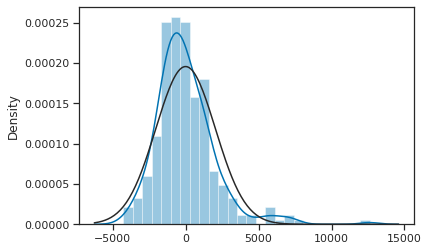

In [28]:
# Plot the distribution of residuals
sns.distplot(results.resid, fit=stats.norm)
plt.savefig('residuals_dist.pdf', bbox_inches='tight')
# plt.title('Distribution of Residuals')
plt.show()

## PCA

In [29]:
pca = PCA().fit(scaled_munro)

### Scree plot

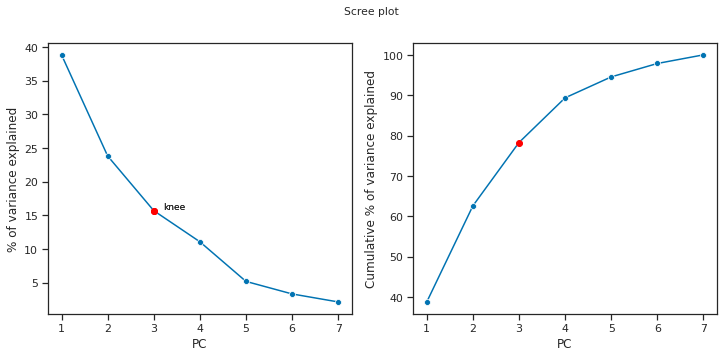

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
y = pca.explained_variance_ratio_ * 100
x = range(1, len(y)+1)

sns.set_style("ticks")

# Scree plot (ax1)
sns.lineplot(x=x, y=y, marker='o', ax=ax1)
ax1.set_ylabel('% of variance explained')
ax1.set_xticks(x)
ax1.set_xlabel('PC')

# Mark the knee
knee = 3
ax1.plot(knee, y[knee-1], color='red', marker='o', label='knee')
ax1.annotate('knee', (knee + 0.2, y[knee-1] + 0.2))

# Cumulative scree plot (ax2)
y2 = y.cumsum()
sns.lineplot(x=x, y=y2, marker='o', ax=ax2)
ax2.set_ylabel('Cumulative % of variance explained')
ax2.set_xticks(x)
ax2.set_xlabel('PC')

# Mark the knee
ax1.plot(knee, y[knee-1], color='red', marker='o', label='knee')
ax1.annotate('knee', (knee + 0.2, y[knee-1] + 0.2))
ax2.plot(knee, y2[knee-1], color='red', marker='o')

plt.suptitle('Scree plot')
plt.show()

- The scree plot shows that the first 3 principal components help explain a considerable amount of variance. The knee is indicated in red. 
- Using the cumulative plot, we see that the first 3 PCs explain ~70% of the variance in the data.

### PCA with fewer components

In [31]:
pc_scores = [f'PC{i+1}' for i in range(knee)]

In [32]:
# Reapply PCA to work with cleaner data
pca = PCA(n_components=knee)

# Transform original data using PC scores
transformed_values = pca.fit_transform(scaled_munro)
df_transformed = pd.DataFrame(transformed_values, columns=pc_scores)

Having removed the less relevant PCs, we now interpret the relevant prinicipal components' loadings:

In [33]:
df_pca = pd.DataFrame(pca.components_, columns=scaled_munro.columns, index=pc_scores).T

cm = sns.diverging_palette(240, 10, as_cmap=True)
df_pca.style.background_gradient(cmap=cm).set_precision(2)

,PC1,PC2,PC3
hotel_count,0.37,-0.03,-0.57
neighbor_count_20,-0.07,0.53,-0.32
nearest_city_dist,-0.31,-0.57,0.09
population_25,0.30,0.50,0.36
population_50,0.43,-0.06,0.57
population_75,0.49,-0.29,0.06
population_100,0.50,-0.23,-0.32


- PC1: People frrom cities 25 - 100km away come to a hotel. They prefer to stay at a place that is not too close to a city.
- PC2: People from within 25km come for a hike. They do not stay at a hotel and they, too, prefer Munros not too close to a city.
- PC3: ... hard to interpret

In [34]:
# Inspect the shape of data after transformation
# sns.pairplot(df_transformed)
# plt.show()

## Linear regression

In [35]:
X = df_transformed.copy()
X['intercept'] = 1  # consider intercept when fitting the model 
y = munro['ascent_count']
model = sm.OLS(y, X)
results = model.fit()

In [36]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ascent_count   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     80.23
Date:                Wed, 31 Mar 2021   Prob (F-statistic):           2.04e-37
Time:                        15:54:49   Log-Likelihood:                -2571.3
No. Observations:                 282   AIC:                             5151.
Df Residuals:                     278   BIC:                             5165.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PC1         1222.0570     80.284     15.222      0.0

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


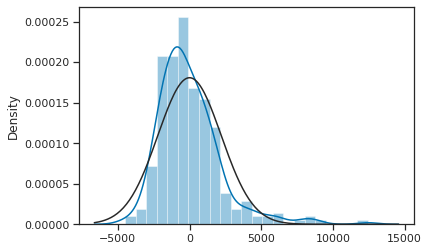

In [37]:
# Plot the distribution of residuals
sns.distplot(results.resid, fit=stats.norm)
# plt.savefig('residuals_dist.pdf', bbox_inches='tight')
# plt.title('Distribution of Residuals')
plt.show()

The above indicates that the PC2 and PC3 are likely due to chance.

## Incorporate features that are not continuous

In [38]:
# Add boolean features
df_transformed[boolean_cols] = munro[boolean_cols]

In [39]:
# One-hot encode categorical features
df_categorical_one_hot = pd.get_dummies(munro[categorical_cols])

# Add categorical features
df_transformed = pd.concat([df_transformed, df_categorical_one_hot], axis=1)

In [40]:
X = df_transformed.copy()
X['intercept'] = 1  # consider intercept when fitting the model 
X[boolean_cols] = munro[boolean_cols].astype(int)
model = sm.OLS(y, X)
results = model.fit()

In [41]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ascent_count   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     43.78
Date:                Wed, 31 Mar 2021   Prob (F-statistic):           9.23e-45
Time:                        15:54:49   Log-Likelihood:                -2542.8
No. Observations:                 282   AIC:                             5104.
Df Residuals:                     273   BIC:                             5136.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [42]:
# Select informative features only
informative_features = results.pvalues[results.pvalues <= 0.01].index

# Remove intercept
informative_features = informative_features[informative_features != 'intercept']

informative_features

Index(['PC1', 'beginner_friendly', 'national_park_Cairngorms'], dtype='object')

In [43]:
X = df_transformed[informative_features].copy()
X['intercept'] = 1  # consider intercept when fitting the model 
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ascent_count   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     116.5
Date:                Wed, 31 Mar 2021   Prob (F-statistic):           7.00e-49
Time:                        15:54:49   Log-Likelihood:                -2544.4
No. Observations:                 282   AIC:                             5097.
Df Residuals:                     278   BIC:                             5111.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
PC1                     

### Visualize residuals

In [44]:
# TODO: fix this. The residuals should be against each independent variable!!!

# Plot the residual plot
# x = range(len(results.resid))
# sns.scatterplot(x=x, y=results.resid)
# sns.lineplot(x=x, y=0, color='red')

# plt.suptitle('Residual Plot')
# plt.ylabel('Residual')
# plt.show()

The plot indicates that the variance of residuals does not change as a function of the independent variables

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


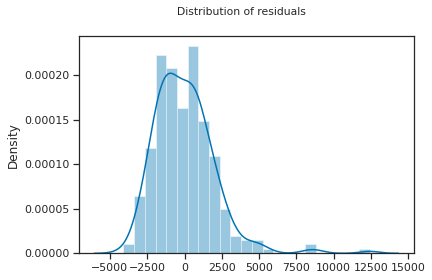

In [45]:
# Plot the distribution of residuals
sns.distplot(results.resid)
plt.suptitle('Distribution of residuals')
plt.show()

Errors are approximately normally distributed this is nice to see, since this is an assumption of linear regression

In [46]:
# # Sanity check that PCA components are uncorrelateds
# pca_data = pd.DataFrame(transformed_values)
# plt.figure(figsize=(10,10))
# sns.heatmap(pca_data.corr(), annot=True, cmap=sns.cm.rocket_r)

# 2. Question – Predicting Munro rating (TODO)

#### THIS IS JUST A TEST!!!!!

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


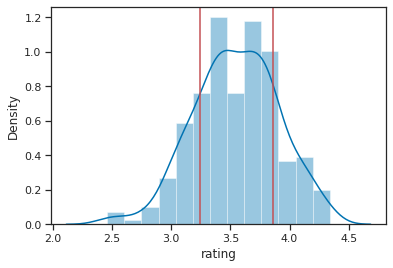

(3.242, 3.8599999999999994)

In [47]:
# Create rating categories
sns.distplot(munro['rating'])
lower = munro['rating'].quantile(0.2)
higher = munro['rating'].quantile(0.8)
plt.axvline(lower, 0, color='r')
plt.axvline(higher, 0, color='r')
plt.show()

lower, higher

In [48]:
# Ideas:
# - Logistic regression
# - k-means
# - KNN

In [49]:
def f(item):
    if item <= lower:
        return 'low'
    elif item >= higher:
        return 'high'
    else:
        return 'average'
munro['rating_new'] = munro['rating'].apply(f)
df_transformed['rating_new'] = munro['rating'].apply(f)

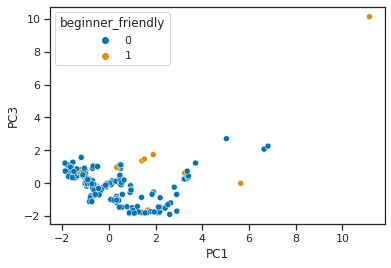

In [50]:
sns.scatterplot(x=df_transformed['PC1'], y=df_transformed['PC3'], hue=munro['beginner_friendly'])
plt.show()

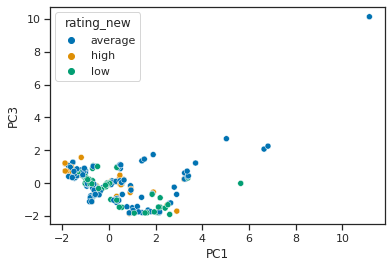

In [51]:

sns.scatterplot(x=df_transformed['PC1'], y=df_transformed['PC3'], hue=munro['rating_new'])
plt.show()

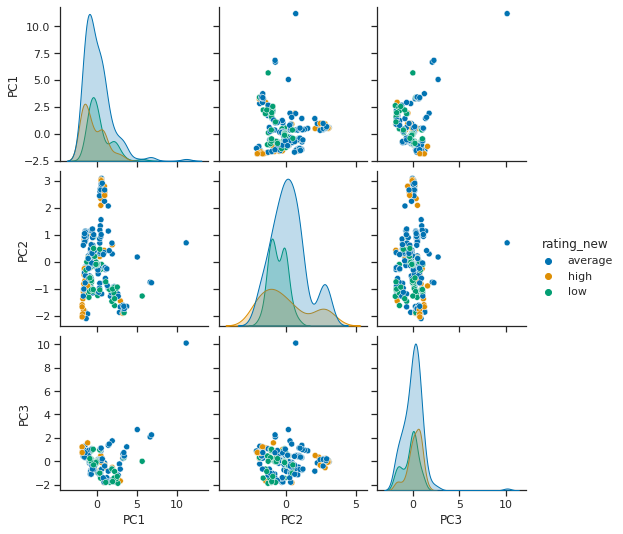

In [52]:
sns.pairplot(df_transformed[['PC1','PC2','PC3', 'rating_new']], hue='rating_new')
# sns.pairplot(df_transformed[['PC1','PC2','PC3']])

In [53]:
def f(item):
    if item == 'Cairngorms':
        return 1
    if item == 'Loch Lomond':
        return 2
    return 0
munro['forest'] = munro['region'].apply(f)

<AxesSubplot:xlabel='altitude', ylabel='ascent_count'>

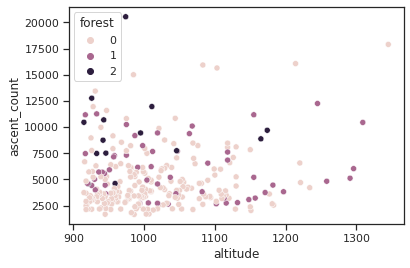

In [54]:
sns.scatterplot(data=munro, y='ascent_count', x='altitude', hue='forest')

In [55]:
from sklearn.cluster import KMeans


K_means_sklearn_model = KMeans(n_clusters=2)
K_means_sklearn_model.fit(df_transformed[['PC2','PC3']])
prediction = K_means_sklearn_model.predict(df_transformed[['PC2','PC3']])
centre = K_means_sklearn_model.cluster_centers_
# print(K_means_sklearn_model.predict(df_transformed[['PC1','PC2', 'rating_new']]))
# print(K_means_sklearn_model.cluster_centers_)

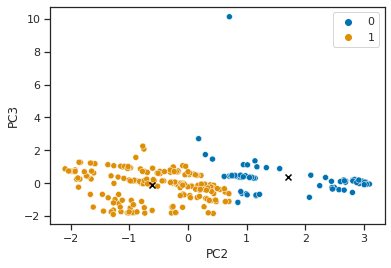

In [56]:
sns.scatterplot(x=df_transformed['PC2'], y=df_transformed['PC3'], hue = prediction)
plt.scatter(centre[0][0],centre[0][1], marker='x', color='black')
plt.scatter(centre[1][0],centre[1][1], marker='x', color='black')

In [57]:
from sklearn.metrics import silhouette_score
# Source: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
x = df_transformed[['PC1', 'PC2', 'PC3']] 
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k).fit(x)
    sil.append(silhouette_score(x, kmeans.labels_, metric='euclidean'))

In [58]:
sil

[0.48531664048208184,
 0.49613484731315005,
 0.5139602137894583,
 0.41900364614954705,
 0.43242111480925816,
 0.4405142276397675,
 0.443135419522937,
 0.458744351970521,
 0.4779217792426213]

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  


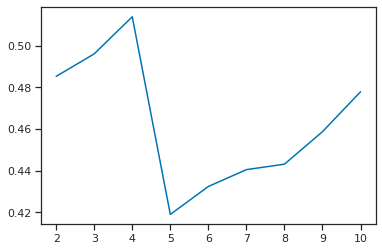

In [59]:
g=sns.lineplot(x=range(2,kmax+1),y=sil)
g.set_xticklabels(range(1,kmax+1))
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ad6e5521-2329-4ba2-9ce8-c0f71fb15c68' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>